## What is Text Classification?

Text classification is the process of categorizing the text into a group of words. By using NLP, text classification can automatically analyze text and then assign a set of predefined tags or categories based on its context**<sup>[1](https://www.analyticsvidhya.com/blog/2020/12/understanding-text-classification-in-nlp-with-movie-review-example-example/)</sup>**. It can be used for a broad range of applications, such as tagging customer feedback into categories or routing support tickets according to their language.

As part of the **[Book](https://www.amazon.in/Natural-Language-Processing-Transformers-Applications/dp/1098103246)**, we’ll tackle this task using a variant of **BERT** called **DistilBERT**. The main advantage of this model is that it achieves comparable performance to BERT, while being significantly smaller and more efficient. This enables us to train a classifier in a few minutes, and if you want to train a larger BERT model you can simply change the checkpoint of the pretrained model. A checkpoint corresponds to the set of weights that are loaded into a given transformer architecture.


> Markdown Text in the .ipynb notebook is text from book to keep track of what the code intends to do

**Step 1: Downloading Dataset from Hugging Face Hub**

We will use Datasets to download the data from the Hugging Face Hub. We can use the list_datasets() function to see what datasets are available on the Hub.

In [1]:
from datasets import list_datasets
all_datasets = list_datasets()
print(f"There are {len(all_datasets)} datasets currently available on the Hub")
print(f"The first 10 are: {all_datasets[:10]}")

There are 4890 datasets currently available on the Hub
The first 10 are: ['acronym_identification', 'ade_corpus_v2', 'adversarial_qa', 'aeslc', 'afrikaans_ner_corpus', 'ag_news', 'ai2_arc', 'air_dialogue', 'ajgt_twitter_ar', 'allegro_reviews']


Let’s load the emotion dataset with the load_dataset() function:

In [2]:
from datasets import load_dataset
emotions = load_dataset("emotion")

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [7]:
train_ds = emotions["train"]

In [8]:
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [9]:
train_ds.column_names

['text', 'label']

In [17]:
import pandas as pd
pd.Series(train_ds["label"]).value_counts().sort_index()

0    4666
1    5362
2    1304
3    2159
4    1937
5     572
dtype: int64

In [18]:
print(train_ds.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(num_classes=6, names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


In [22]:
train_ds.supervised_keys

SupervisedKeysData(input='text', output='label')

### From Datasets to DataFrames

Although Datasets provides a lot of low-level functionality to slice and dice our data, it is often convenient to convert a Dataset object to a Pandas DataFrame so we can access high-level APIs for data visualization. To enable the conversion, Datasets provides a set_format() method that allows us to change the output format of the Dataset. Note that this does not change the underlying data format

In [23]:
emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [31]:
emotions["train"].features["label"]

ClassLabel(num_classes=6, names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)

Labels are represented as integers, so let’s use the int2str() method of the label feature to create a new column in our DataFrame with
the corresponding label names

In [25]:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)
df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


### Looking at the Class Distribution

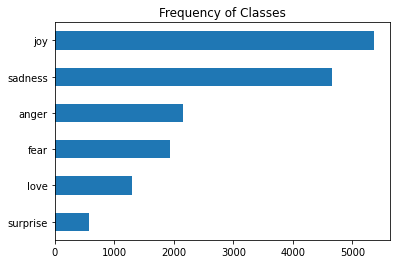

In [32]:
import matplotlib.pyplot as plt
df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

### How Long Are Our Tweets?

Transformer models have a maximum input sequence length that is referred to as the maximum context size. For applications using DistilBERT, the maximum context size is 512 tokens, which amounts to a few paragraphs of text.

Text(0.5, 0.98, '')

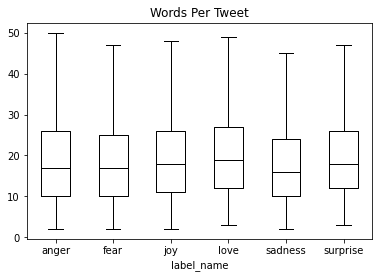

In [33]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_name", grid=False,
showfliers=False, color="black")
plt.suptitle("")

Let’s convert these raw texts into a format suitable for Transformers! While we’re at it, let’s also reset the output format of our dataset since we don’t need the DataFrame format anymore.

In [34]:
emotions.reset_format()